In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt

In [6]:
p1  = "/home/yashjonjale/Documents/intern_proj/Model/logs/params/24_6/best_params_5.json"
p2 = "/home/yashjonjale/Documents/intern_proj/Model/logs/params/24_6/best_params_entire.json"
p3 = "/home/yashjonjale/Documents/intern_proj/Model/logs/params/24_6/best_params_entire_2.json"
p4 = "/home/yashjonjale/Documents/intern_proj/Model/logs/params/24_6/best_params_entire_3.json"

In [7]:
# load the json files from the paths
with open(p1) as f:
    data1 = json.load(f)
with open(p2) as f:
    data2 = json.load(f)
with open(p3) as f:
    data3 = json.load(f)
with open(p4) as f:
    data4 = json.load(f)

In [8]:
#load the final_data.npz
final_data = np.load("/home/yashjonjale/Documents/intern_proj/Model/Dataset/final_data.npz")
arr = final_data['arr_0']

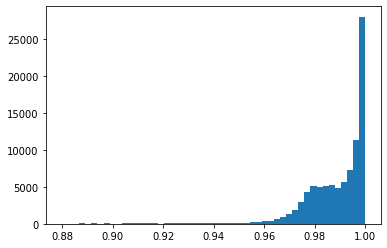

In [9]:
sim_vecs = arr[:, 0]
sim_vecs = np.array(sim_vecs)
sim_vecs = sim_vecs.reshape(-1, 1)
#mean
mean = np.mean(sim_vecs)
#std
std = np.std(sim_vecs)
#variance
var = np.var(sim_vecs)
#median
median = np.median(sim_vecs)
#min
min_val = np.min(sim_vecs)
#max
max_val = np.max(sim_vecs)

#plot the histogram
plt.hist(sim_vecs, bins=50)
plt.show()

In [10]:
# print the statistics
print("mean: ", mean)
print("std: ", std)
print("var: ", var)
print("median: ", median)
print("min: ", min_val)
print("max: ", max_val)


mean:  0.988531611417001
std:  0.013866960267468352
var:  0.00019229258705954596
median:  0.9928586735630986
min:  0.8794161318827849
max:  1.0000000000000002


In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#r2score
from sklearn.metrics import r2_score
X = arr[:, 3:]
y = arr[:, 2]
real = arr[:, 1]#km_wildtype
#find indices where sim_vecs is greater than 0.99
indices = np.where(sim_vecs>0.99)
indices = indices[0]
#remove the indices from X,y,real
X = np.delete(X, indices, axis=0)
y = np.delete(y, indices, axis=0)
real = np.delete(real, indices, axis=0)
sz = 0.2

X_train, X_test, y_train, y_test,r_train,r_test = train_test_split(X, y,real, test_size=(1-sz), random_state=42)
D_train=xgb.DMatrix(data=X_test, label=y_test)
D_test=xgb.DMatrix(data=X_train, label=y_train)


ImportError: cannot import name '_HTMLDocumentationLinkMixin' from 'sklearn.utils._estimator_html_repr' (/home/yashjonjale/.local/lib/python3.10/site-packages/sklearn/utils/_estimator_html_repr.py)

In [ ]:
print(f"Following are the results for best_params_5_3200")
best = data3
num_round = best['num_rounds']
del best['num_rounds']
params={'max_depth': int(np.round(best['max_depth'])),
        'learning_rate': best['learning_rate'],
        'min_child_weight': best['min_child_weight'],
        'reg_alpha': best['reg_alpha'],  # L1 regularization
        'reg_lambda': best['reg_lambda'],  # L2 regularization
        'tree_method': 'gpu_hist',  # Use GPU
        'predictor': 'gpu_predictor',  # Use GPU for predictions
        'sampling_method': 'gradient_based',
        'eval_metric': 'rmse'}
best_model = xgb.train(params, xgb.DMatrix(X_train,label=y_train), int(num_round), verbose_eval=False)
predictions = best_model.predict(xgb.DMatrix(X_test, label=y_test)) 
test_accuracy = r2_score(y_test + r_test, predictions + r_test)
print("Test Accuracy (km_vals): {:.2f}".format(test_accuracy))
test_acc_deltas = r2_score(y_test, predictions)
print("Test Accuracy (delta): {:.2f}".format(test_acc_deltas))

#find the training accuracy
predictions = best_model.predict(xgb.DMatrix(X_train, label=y_train))
train_accuracy = r2_score(y_train + r_train, predictions + r_train)
print("Train Accuracy (km_vals): {:.2f}".format(train_accuracy))
# make a scatter plot
plt.scatter(y_test +r_test, predictions+r_test)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()


In [5]:
#now we will make multiple intervals of y and sim_vecs, and find the r2 score for each interval

# make the different intervals ina a grid
intervals = list(np.linspace(0, 2, 11))
intervals_ = list(np.array([0.9999,0.999,0.99,0.9]))
r2_scores = []
for k in range(4):
    r2_scores.append([])

for i in range(1,len(intervals)):
    up = intervals[i]
    down = intervals[i-1]
    # find the indices where y is in the interval
    for j in range(0,len(intervals_)):
        threshold = intervals_[j]
        indices = np.where((y>=down) & (y<=up) & (sim_vecs>=threshold))
        indices = indices[0]
        if len(indices) == 0:
            continue
        # find the r2 score
        predictions = best_model.predict(xgb.DMatrix(X[indices], label=y[indices]))
        r2 = r2_score(y[indices], predictions[indices])
        r2_scores[j].append(r2)
        print(f"Interval: {down} to {up} and {threshold} has r2 score: {r2}")
    
# plot the r2 scores
# make a meshgrid
X, Y = np.meshgrid(intervals, intervals_)
r2_scores = np.array(r2_scores)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, r2_scores, cmap='viridis')
ax.set_xlabel('Interval')
ax.set_ylabel('Threshold')
ax.set_zlabel('r2_score')
plt.show()

#use plotly for an interacting surface plot and save to html file
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=r2_scores, x=intervals, y=intervals_)])
fig.update_layout(title='r2 scores for different intervals and thresholds',
                  scene = dict(
                    xaxis_title='Interval',
                    yaxis_title='Threshold',
                    zaxis_title='r2_score'))
fig.show()

fig.write_html("/home/yashjonjale/Documents/intern_proj/Model/logs/params/24_6/r2_scores.html")

    



[[0.   0.  ]
 [0.11 0.22]
 [0.33 0.44]
 [0.56 0.67]
 [0.78 0.89]
 [1.   1.  ]]


In [ ]:
#Now find indices in r_test for which the value is greater than 0.95
indices = np.where(r_test > 0.95)
#Now make a scatter plot for these indices
plt.scatter(y_test[indices], predictions[indices])
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.show()

#find r2 score for these indices
r2 = r2_score(y_test[indices]+r_test[indices], predictions[indices]+r_test[indices])
print("R2 score for values greater than 0.95: ", r2)

In [ ]:
#make scatter plots for different ranges of r_test
indices = np.where(r_test < 0.95)
plt.scatter(y_test[indices][0], predictions[indices])
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [ ]:
#make a plot of r2 scores for different ranges of r_test
# make the ranges
ranges = np.linspace(-5, 5, 11)
r2_scores = []
for i in range(10):
    indices = np.where((r_test > ranges[i]) & (r_test < ranges[i+1]))
    r2 = r2_score(y_test[indices]+r_test[indices], predictions[indices]+r_test[indices])
    r2_scores.append(r2)